In [37]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

In [38]:
target = cv2.imread('dataset/dataset_updated/local/drawings.jpeg')
target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
target = cv2.GaussianBlur(target, (5,5), 0)
grayscaled_target = cv2.cvtColor(target, cv2.COLOR_RGB2GRAY)

In [39]:
def process_images(folder_path, gray_list):
    for image_name in os.listdir(folder_path):
        image_path = f"{folder_path}/{image_name}"
        image = cv2.imread(image_path)
        if image is None:
            continue
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
        gray_image = cv2.equalizeHist(gray_image)
        gray_list.append(gray_image)

In [40]:
PATH = 'dataset/dataset_updated/training_set/'
categories = ['drawings', 'engraving', 'iconography', 'painting', 'sculpture']
image_sets = {category: [] for category in categories}

for category in categories:
    folder_path = f"{PATH}/{category}"
    process_images(folder_path, image_sets[category])


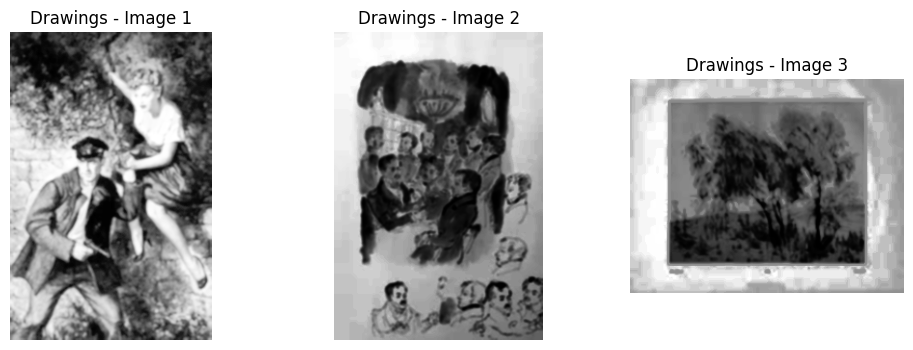

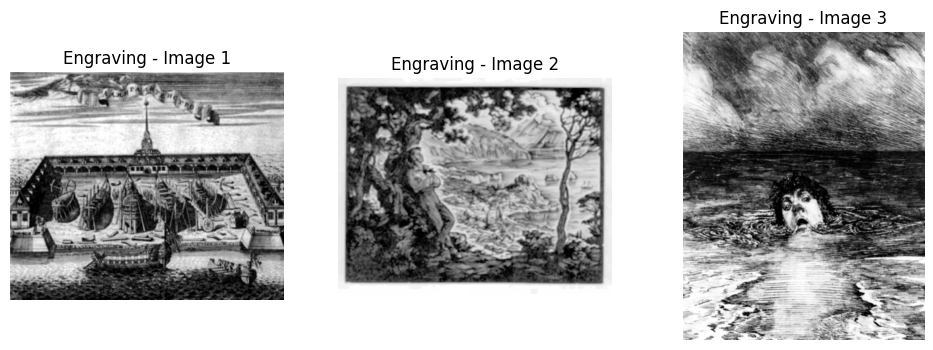

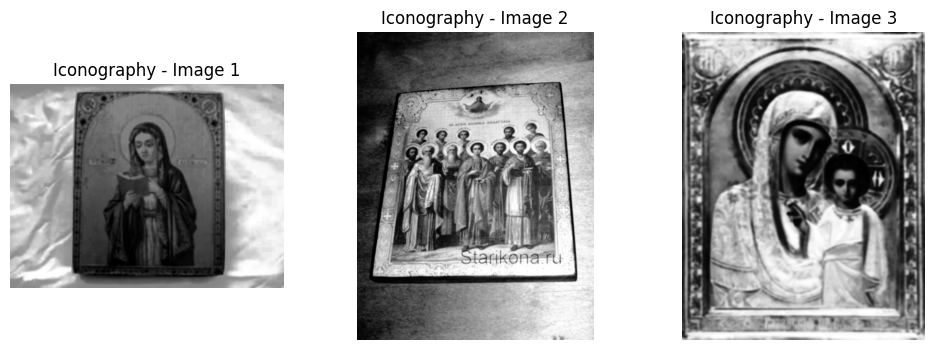

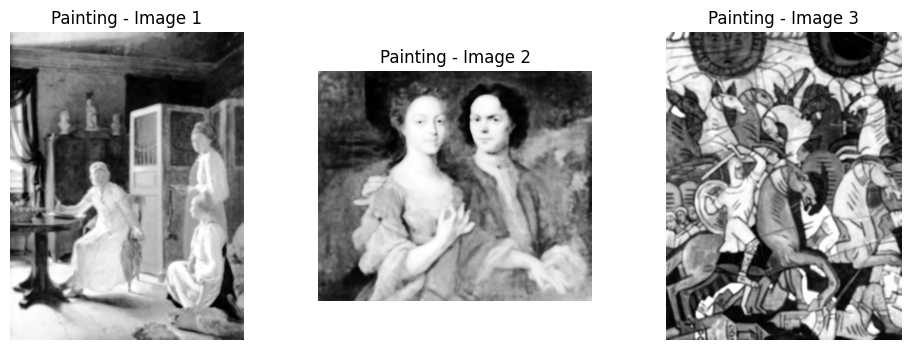

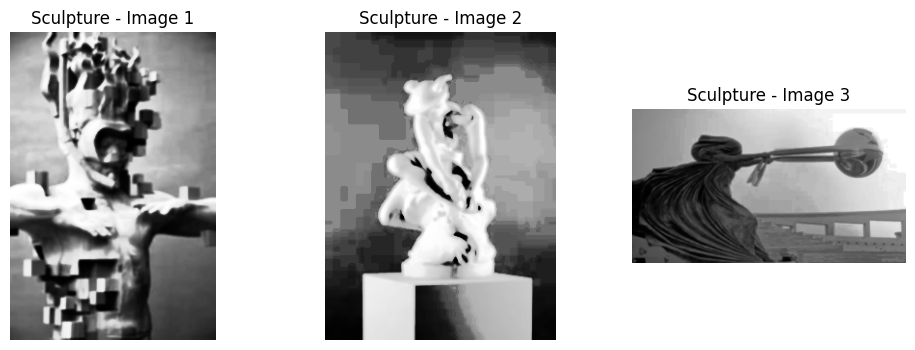

In [41]:
def display_random_images(images, class_name):
    random_images = random.sample(images, 3) if len(images) >= 3 else images
    plt.figure(figsize=(12, 4))
    for i, image in enumerate(random_images):
        plt.subplot(1, 3, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title(f"{class_name} - Image {i + 1}")
    plt.show()

for category in categories:
    display_random_images(image_sets[category], category.capitalize())

In [ ]:
def find_best_match(target_image, image_sets, detector_type="SIFT"):
    if detector_type == "SIFT":
        detector = cv2.SIFT_create()
        matcher = cv2.FlannBasedMatcher(dict(algorithm=1, trees=10), dict(checks=100))
        use_lowe_ratio = True
    elif detector_type == "ORB":
        detector = cv2.ORB_create()
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        use_lowe_ratio = False
    else:
        raise ValueError("Invalid detector type. Use 'SIFT' or 'ORB'.")

    target_keypoints, target_descriptors = detector.detectAndCompute(target_image, None)
    if target_descriptors is None:
        raise ValueError("No descriptors found in the target image.")

    best_matches = 0
    best_matches_data = None

    for category, images in image_sets.items():
        for img in images:
            img_keypoints, img_descriptors = detector.detectAndCompute(img, None)
            if img_descriptors is None:
                continue

            matches = matcher.knnMatch(target_descriptors, img_descriptors, k=2) if use_lowe_ratio else matcher.match(target_descriptors, img_descriptors)
            
            good_matches = []
            if use_lowe_ratio:
                for m, n in matches:
                    if m.distance < 0.7 * n.distance:
                        good_matches.append(m)
            else:
                good_matches = matches

            if len(good_matches) > best_matches:
                best_matches = len(good_matches)
                best_matches_data = {
                    'img': img,
                    'keypoints': img_keypoints,
                    'matches': good_matches,
                    'category': category
                }

    return best_matches_data

In [43]:
sift_result = find_best_match(grayscaled_target, image_sets, detector_type="SIFT")
orb_result = find_best_match(grayscaled_target, image_sets, detector_type="ORB")

# Display matching results
def display_results(target, target_keypoints, result, title):
    if result:
        result_image = cv2.drawMatches(
            target,
            target_keypoints,
            result['img'],
            result['keypoints'],
            result['matches'],
            None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        plt.figure(figsize=(12, 6))
        plt.title(title)
        plt.imshow(result_image)
        plt.axis('off')
        plt.show()
    else:
        print(f"No matches found for {title}.")

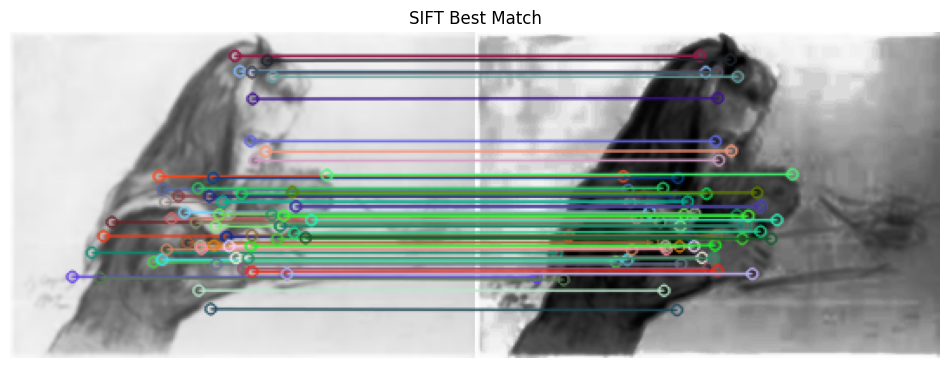

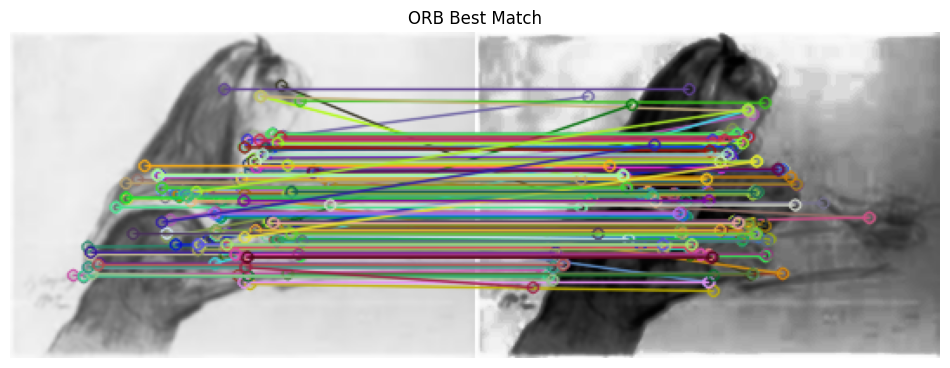

In [44]:
# Display SIFT results
sift_keypoints, _ = cv2.SIFT_create().detectAndCompute(grayscaled_target, None)
display_results(target, sift_keypoints, sift_result, "SIFT Best Match")

# Display ORB results
orb_keypoints, _ = cv2.ORB_create().detectAndCompute(grayscaled_target, None)
display_results(target, orb_keypoints, orb_result, "ORB Best Match")